## Compared to v1 and v2, v3 models tree-growth including cell survival d, such that each cell reaching generation k has a chance (1-d) to die (independently of other cells) before dividing to the next generation or becoming quiescent.
## To speed up this procedure, we pre-compute the probabilities of the families from which observed families are recovered. The pre-computation occurs on a lattice of possible rho values (e.g., 0, 0.001, 0.002, ..., 1). 

In [1]:
import itertools as itt
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import os
import pandas as pd
import pickle
import scipy.optimize as spo
import scipy.special as spsp
import scipy.stats as sps
import seaborn as sns
import time

from matplotlib.ticker import FixedLocator

mpl.rcParams['axes.titlesize'] = 'xx-large'
mpl.rcParams['axes.labelsize'] = 'xx-large'
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 0.5
mpl.rcParams['legend.fontsize'] = 'large'

path_proj = os.getcwd()+ '/'
path_sc = path_proj + 'csv/Single_cell/'
path_sort = path_proj + 'csv/Sort/'
path_plot = path_proj + 'figures/'
print(path_proj)

#LOAD THE PROCESSED DATA
df = pd.read_csv(path_sc+'Pooled_data.csv', sep=';', decimal=',')

#GLOBAL VARIABLES FOR ITERATION
conds = ['P', 'P+ILs']
or_cells = ['SLAM-HSC', 'ST-HSC', 'MPP']

#SET A RANDOM SEED TO REPLICATE THE BOOTSTRAP CONFIDENCE INTEVALS
#BASED ON RANDOM SAMPLING WITH REPLACEMENT
np.random.seed(123)

/home/giulio/Desktop/Generational_multiplex_analysis/


In [2]:
#IMPORTANT: SAMPLING PROBABILITY AND SURVIVAL PROBABILITY MUST BE SPECIFIED FROM THE USER! 
r_sample = 0.71
r_surv = 1.

In [3]:
#NOTE: A FAMILY VECTOR IS THE VECTOR OF CELL COUNTS PER GENERATION (ONE GENERATION PER VECTOR ENTRY);

#BELOW ARE THE FUNCTIONS AND CLASSES TO DEFINE FULL AND SAMPLED FAMILY VECTORS

#GIVEN A FAMILY VECTOR, POPULATE THE NEXT GENERATION WITH ALL POSSIBLE COUNTS THAT ARE PHYSICALLY POSSIBLE
#(HERE IT IS ASSUMED THAT EACH DIVIDING CELLS PRODUCES TWO CELLS IN THE NEXT GENERATION AND THAT CELLS CAN DIE BEFORE DIVIDING OR BECOMING QUIESCENT)
def fam_generator(max_gen, remove_empty=False):
    fam_vec = np.vstack((np.zeros(1), np.ones(1)))
    if max_gen > 0:
        for i in range(1,max_gen+1):            
            next_gen_counts = np.arange(0,2**i+1)
            next_fam_vec = np.repeat(fam_vec, len(next_gen_counts), axis=0)
            next_gen_counts = np.tile(next_gen_counts, len(fam_vec))[None,:].T
            next_fam_vec = np.hstack((next_fam_vec,next_gen_counts))
            mult = 2.**-np.arange(0,next_fam_vec.shape[1])
            is_fam_possible = (next_fam_vec * mult).sum(axis=1)<=1
            fam_vec = next_fam_vec[is_fam_possible]
    if remove_empty:
        fam_vec = fam_vec[fam_vec.sum(axis=1)>0]
    return fam_vec


fam_generator(6)[:3]

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 2.]])

In [4]:
#BELOW ARE THE FUNCTIONS TO CALCLUATE THE DISTRIBUTION AND CONFIDENCE INTERVALS
#OF DATA IN A GIVEN SUPPORT (SIMILARLY AS IN NOTEBOOK 2)

#TRANSFORM THE PANDAS DATAFRAME OF A FAMILY INTO A FAMILY VECTOR
def df_fam_to_vec(dff, max_g):
    res = np.zeros(max_g+1)
    gens, counts = np.unique(dff.Generation, return_counts=True)
    res[gens] = counts
    return res

def epmf_on_support(data, support, bool_norm=True):
    classes, counts = np.unique(data, return_counts=True)
    counts_sum = counts.sum()
    if counts_sum == 0:
        return np.zeros(len(support))
    elif bool_norm:
        return np.hstack([counts[classes==cl] if any(classes==cl) else np.zeros(1) for cl in support]
                        )/counts_sum
    else:
        return np.hstack([counts[classes==cl] if any(classes==cl) else np.zeros(1) for cl in support])
    
def stat_bootCI(func, args, data, n_iter=250000, bool_trim01=True):
    stat = func(data, *args)
    boot_stat = np.array([func(data[boot_index], *args)
                          for boot_index in np.random.choice(len(data), size=(n_iter,len(data)))])
    boot_per = np.percentile(boot_stat, q=[97.5, 2.5], axis=0)
    boot_ci = 2.*stat - boot_per
    if bool_trim01:
        boot_ci[0,boot_ci[0,:]<0.] = np.zeros((boot_ci[0,:]<0.).sum())
        boot_ci[1,boot_ci[1,:]>1.] = np.ones((boot_ci[1,:]>1.).sum())
    return stat, boot_ci

In [5]:
#PROBABILITY THAT A BETA-BINOMIAL DISTRIBUTION, WITH PARAMETERS n, a, b, EQUALS k
def bb_dist(k, n, a, b):
    if a == 0.:
        if k==0.:
            return 1.
        else:
            return 0.
    elif b == 0.:
        if k == n:
            return 1.
        else:
            return 0.
    else:
        return spsp.binom(n,k) * spsp.beta(k+a,n-k+b) / spsp.beta(a,b)
    
#PROBABILITY THAT A BINOMIAL DISTRIBUTION, WITH PARAMETERS n, R, EQUALS k    
def bino_dist(k, n, r):
    if r == 0.:
        if k==0.:
            return 1.
        else:
            return 0.
    elif r == 1.:
        if k == n:
            return 1.
        else:
            return 0.
    else:
        return spsp.binom(n, k) * r**(k) * (1.-r)**(n-k)

In [6]:
#BETA-BINOMIAL (BB) MODEL FOR CELL DIVISION,
#WHERE A FAMILY DEVELOPS FROM A 1 CELL IN GENERATION 0 ITERATIVELY AS FOLLOWS:
#THE NUMBER OF CELLS THAT DIVIDE FROM GENERATION i TO i+1 FOLLOWS A BETA-BINOMIAL DISTRIBUTION
#PARAMETRISED SO THAT ONE CELL DIVIDES WITH PROBABILITY p, AND THE CELLS IN THE SAME GENERATION
#DECIDE TO DIVIDE WITH (INTRACLASS) CORRELATION rho.
#IN ACCORDANCE WITH EXPERIMENTAL DATA, THE CELLS FROM FULL FAMILY VECTOR GROWN UNDER THE BB MODEL
#ARE THEN SAMPLED (INDEPENDENTLY AND WITH EQUAL DISTRIBUTION) WITH PROBABILITY r.    
    
#RECURSIVE FUNCTIONS TO CALCULATE THE PROBABILITY OF A FAMILY VECTOR UNDER THE BB MODEL (WITH DEATH) FOR 1>rho>0, =0, =1
    
def rec_model_rho(m, alpha, beta, u_start, u_end, r_surv):
    if len(m) == 1:
        return bino_dist(m[0], u_end, r_surv) 
    gen_mult = [
        bino_dist(u, u_end, r_surv) * bb_dist(m[0], u, beta[0], alpha[0])
    for u in np.arange(u_start, u_end+1)]
    return sum([gm * rec_model_rho(m[1:], alpha[1:], beta[1:], u_start=m[1], u_end=2*(u-m[0]), r_surv=r_surv)
        for gm,u in zip(gen_mult, np.arange(u_start, u_end+1))
        if gm > 0.])

def rec_model_rho0(m, p, u_start, u_end, r_surv):
    if len(m) == 1:
        return bino_dist(m[0], u_end, r_surv) 
    gen_mult = [
        bino_dist(u, u_end, r_surv) * bino_dist(m[0], u, p[0])
    for u in np.arange(u_start, u_end+1)]
    return sum([gm * rec_model_rho0(m[1:], p[1:], u_start=m[1], u_end=2*(u-m[0]), r_surv=r_surv)
        for gm,u in zip(gen_mult, np.arange(u_start, u_end+1))
        if gm > 0.])

def rec_model_rho1(m, p, u_start, u_end, r_surv):
    #print(m[0], p[0], u_start, u_end, r_surv)
    if len(m) == 1:
        return bino_dist(m[0], u_end, r_surv) * (1-p[0])
    gen_mult = [
        bino_dist(u, u_end, r_surv) * p[0]
    for u in np.arange(u_start, u_end+1)]
    return sum([gm * rec_model_rho1(m[1:], p[1:], u_start=m[1], u_end=2*(u-m[0]), r_surv=r_surv)
        for gm,u in zip(gen_mult, np.arange(u_start, u_end+1))
        if gm > 0.])

#PROBABILITY OF OBSERVING THE FAMILY VECTOR m UNDER THE BB MODEL WITH PARAMETERS p, rho, r_surv

def pmf_m(m, p, r_surv, rho):
    if rho == 0.:
        res = rec_model_rho0(m=m, p=p, u_start=0, u_end=1, r_surv=r_surv)
    elif rho == 1.:
        where_cells = m.nonzero()[0]
        #if len(where_cells) <= 1:
        #    res = rec_model_rho1(m, p=p, u_start=0, u_end=1, r_surv=r_surv)
        if len(where_cells) == 0:
            #res = rec_model_rho1(m, p=p, u_start=0, u_end=1, r_surv=r_surv)
            res = sum([
                rec_model_rho1(m[:gen+1], p=p[:gen+1], u_start=0, u_end=1, r_surv=r_surv)
                for gen in range(len(m))])
        elif len(where_cells) == 1:
            reached_gen = where_cells[0]
            res = rec_model_rho1(m[:reached_gen+1], p=p[:reached_gen+1], u_start=0, u_end=1, r_surv=r_surv)
        else:
            res = 0.
    else:
        alpha = np.multiply(p, (1.-rho)/rho)
        beta = np.multiply(np.subtract(1., p), (1.-rho)/rho)
        res = rec_model_rho(m=m, alpha=alpha, beta=beta, u_start=0, u_end=1, r_surv=r_surv)
    return res

    
#PROBABILITY OF OBSERVING THE SAMPLED FAMILY VECTOR v,
#SAMPLING EACH CELL FROM THE FAMILY VECTOR m WITH SUCCESS RATE r
def pmf_v_given_m(v, m, r):
    return np.prod([bino_dist(v[i], m[i], r)
                    for i in range(len(v))]) / (1.-((1.-r)**sum(m)))

In [7]:
#CLASS FOR FULL FAMILY VECTORS
class Family_vector(object):
    #Initialize family vector array and range
    def __init__(self, fv):
        self.fv = fv
        if (fv == 0).all():
            self.range = None
        else:
            self.range = np.arange(len(fv))[fv>0].max() - np.arange(len(fv))[fv>0].min()

        self.sv_lst = None
        self.sv_prob_lst = None

        self.fv_rhos = None
        self.fv_prob = None
    
    #Method to select all family vectors from a list that can be sampled from fv and their sampling probability
    def select_sub_family_vector(self, fv_ary, r):
        if (self.fv == 0).all():
            self.sv_lst = np.array([Family_vector(self.fv)])
            self.sv_prob_lst = np.array([1.])        
        else:
            sub_fams = fv_ary[(fv_ary<=self.fv).all(axis=1)]
            self.sv_lst = np.array([Family_vector(k) for k in sub_fams])
            self.sv_prob_lst = np.array([pmf_v_given_m(k, self.fv, r) for k in sub_fams])        
    
    #Method to calculate the probability of fv under the bb model for a list of rho values
    def generate_fv_prob(self, p, r_surv, rhos):
        self.fv_rhos = rhos
        self.fv_prob = {rho: pmf_m(self.fv, p, r_surv, rho) for rho in rhos}


In [8]:
#PROBABILITY OF OBSERVING FRAY/RANGE EQUAL TO k UNDER THE BB MODEL rho, p, r_surv
#GENERATING FAMILY VECTORS IN lst_Fam_vec, THEN SAMPLED WITH SUCCESS RATE r 
#Fray probability must be conditioned on the event that the bb model produce a non-empty family
def fray_prob(k, rho, lst_Fam_vec):
    #Probability of the model returning non-empty family (for conditioning)
    cond_prob = 1. - [Fv.fv_prob[rho] for Fv in lst_Fam_vec if (Fv.fv==0).all()][0]
    return sum([
        #Fv.fv_prob[Fv.fv_prob[:,0]==rho, 1][0]
        Fv.fv_prob[rho] / cond_prob#[0]
        * sum([Fv.sv_prob_lst[i] for i,sv in enumerate(Fv.sv_lst) if sv.range==k])
        for Fv in lst_Fam_vec])
    

#NEGATIVE LOG-LIKELIHOOD OF FRAY/RANGE DATA
def func_alogb(a,b):
    if a == 0.:
        return 0.
    else:
        if b <=0.:
            return -np.inf
        else:
            return a * np.log(b)

def log_like_data(rho, lst_Fam_vec, fray_freq):
    fray_pb = [fray_prob(k, rho, lst_Fam_vec)
               if fray_freq[k] != 0
               else 0.
               for k in range(len(fray_freq))]
    return sum([func_alogb(fray_freq[k], fray_pb[k])
                for k in range(len(fray_freq))])

4

 ST-HSC P 77
[0.95806029 0.7373461  0.11688312 0.01587302 0.        ]
Family vectors generation time: 0.0023117870000000096
Probabilities calculation time: 20.924799737
MLE rho time: 4.314891168000003
Boot ci fray epmf time: 10.513817038000003
Boot ci rho time: 389.89252415100003
LR test pval= 1.4214480545242337e-10
Best-fit rho: 0.799 in 95% CI (0.682,1.598)


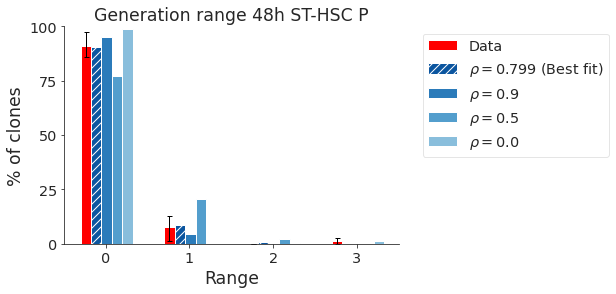

In [9]:
df = df[df.Culture_time=='48h']#Use 48h data only
boot_iter = 250000
boot_n_rho = 100
rhos = np.arange(0,1.001,0.001)

for n_oc,oc in enumerate(or_cells):
    for n_cnd,cnd in enumerate(conds):
        #if n_oc!=1 or n_cnd!=0:
        #    continue
        #df_temp = df[(df.Original_cell==oc)&(df.Culture_condition==cnd)]
        
        #SET MAX GENERATION AND ALL SAMPLED FAMILY VECTORS FROM THE DATA 
        max_g = df_temp.Generation.max()
        uni_fams = np.unique(df_temp.Family)
        print(max_g)
        print('\n', oc, cnd, len(uni_fams))
        fam_vec = np.array([df_fam_to_vec(df_temp[df_temp.Family==fam], max_g)
                            for fam in uni_fams])
        
        #ESTIMATE p FOR THE BB MODEL, THE PROBABILITY FOR A CELL TO DIVIDE TO NEXT GENERATION 
        cc_pop = fam_vec.sum(axis=0)*(2.** -np.arange(max_g+1))
        p_div = np.array([cc_pop[i+1:].sum()/cc_pop[i:].sum() for i in np.arange(len(cc_pop)-1)] + [0.])
        print(p_div)
        #CALCULATE THE OBSERVED FRAY/RANGE, AND ITS DISTRIBUTION, FROM THE DATA
        fray_data = np.array([df_temp[df_temp.Family==fam].Generation.max()
                              - df_temp[df_temp.Family==fam].Generation.min()
                              for fam in uni_fams])
        fray_support = np.arange(max_g)
        fray_freq = epmf_on_support(fray_data, fray_support, bool_norm=False)
        
        #Generate all family vectors up to max observed depth d
        start = time.process_time()
        ary_fam_vec = fam_generator(max_g, remove_empty=False)
        lst_Fam_vec = [Family_vector(fv) for fv in ary_fam_vec]
        end = time.process_time()
        print('Family vectors generation time:', end-start)
        
        #Calculate probabilities for sampled families and generation from bb model 
        start = time.process_time()
        for Fv in lst_Fam_vec:
            Fv.generate_fv_prob(p=p_div, r_surv=r_surv, rhos=rhos)
            Fv.select_sub_family_vector(ary_fam_vec, r=r_sample)
        end = time.process_time()
        print('Probabilities calculation time:', end-start)
        
        #MLE rho estimation
        start = time.process_time()
        log_like_data_rho = np.array([log_like_data(rho, lst_Fam_vec, fray_freq) for rho in rhos])
        est_rho = rhos[np.argmax(log_like_data_rho)]
        end = time.process_time()
        print('MLE rho time:', end-start)
        
        #UNCOMMENT TO CALCULATE BOOTSTRAP CIs
        #BOOTSTRAP EPMF OF FRAY DISTRIBUTION
        start = time.process_time()
        fray_epmf, boot_ci = stat_bootCI(func=epmf_on_support, args=(fray_support,), data=fray_data)
        end = time.process_time()
        print('Boot ci fray epmf time:', end-start)
        
        #BOOTSTRAP RHO
        start = time.process_time()
        boot_rho = []
        for boot_data in np.random.choice(fray_data, size=(boot_n_rho,len(fray_data))):
            boot_freq = epmf_on_support(boot_data, fray_support, bool_norm=False)
            boot_log_like_data_rho = np.array([log_like_data(rho, lst_Fam_vec, boot_freq) for rho in rhos])
            boot_est_rho = rhos[np.argmax(boot_log_like_data_rho)]
            boot_rho.append(boot_est_rho)
        end = time.process_time()
        print('Boot ci rho time:', end-start)
        
        #Fray distribution under the BB model for other values of rho
        rho_lst = np.array([est_rho, 0.9, 0.5, 0.0])
        fray_pmf = {str(rho):[fray_prob(gen, rho, lst_Fam_vec)
                              for gen in fray_support] for rho in rho_lst}
        
        #LIKELIHOOD-RATIO TEST (EXTRA)
        neg_log_like_H0 = -log_like_data(0., lst_Fam_vec, fray_freq)
        neg_log_like_H1 = -log_like_data(est_rho, lst_Fam_vec, fray_freq)
        like_ratio_stat = 2. * (neg_log_like_H0 - neg_log_like_H1)
        pval = sps.chi2.sf(like_ratio_stat, df=1)
        print('LR test pval=', pval)
        
        #SAVE VARIABLES THAT TAKE A LONG TIME TO CALCULATE
        with open('./pickled_data/AAFray_ci_'+oc+cnd, 'wb') as fp:
            pickle.dump((fray_epmf,boot_ci,est_rho,boot_rho,fray_pmf,pval), fp)
        #END COMMENT HERE
        
        with open('./pickled_data/AAFray_ci_'+oc+cnd, 'rb') as fp:
            fray_epmf,boot_ci,est_rho,boot_rho,fray_pmf,pval = pickle.load(fp)

        #PRINT RHO CI
        boot_per_rho = np.percentile(boot_rho, q=[97.5, 2.5], axis=0)
        boot_ci_rho = 2.*est_rho - boot_per_rho
        print('Best-fit rho: {} in 95% CI ({},{})'.format(round(est_rho,3),round(boot_ci_rho[0],3),round(boot_ci_rho[1],3)))            
        
        #PLOTTING CODE
        rho_lst = np.array([est_rho, 0.9, 0.5, 0.0])###THIS IS ADDED FOR WHEN THE PART ABOVE IS COMMENTED
        width = 0.5/len(rho_lst)
        t_cols = sns.color_palette('Blues', n_colors=6)[::-1]
        color_dct = {str(est_rho):t_cols[0], '0.9':t_cols[1],
                     '0.5':t_cols[2], '0.0':t_cols[3]}
        shift_dct = {str(rho_lst[k]):-0.30 + (k+1)*0.125 for k in range(len(rho_lst))}    
        sns.set_style("ticks")
        fig, ax = plt.subplots()
        ax.bar(x=fray_support-0.30, height=fray_epmf, width=width, align='edge',
           color='Red', label='Data')
        for rho in rho_lst:
            if rho == est_rho:
                ax.bar(x=fray_support+shift_dct[str(rho)], height=fray_pmf[str(rho)],
                       width=width, align='edge', color=color_dct[str(rho)], hatch='///',
                       label=r'$\rho = $'+str(round(rho, 3))+' (Best fit)')
            else:
                ax.bar(x=fray_support+shift_dct[str(rho)], height=fray_pmf[str(rho)],
                       width=width, align='edge', color=color_dct[str(rho)],
                       label=r'$\rho = $'+str(round(rho, 3)))     
        xx_fray = np.add(np.arange(len(fray_epmf)), (width/2.)-0.30)
        for k in range(len(fray_epmf)):
            ax.plot([xx_fray[k]]*2, [boot_ci[0,k], boot_ci[1,k]],
                     color='Black', ls='-', lw=1., mfc='Black', mec='Black',
                     marker='_', mew=1, ms=5.)
        sns.despine(fig=fig)
        ax.set_xlabel('Range', fontsize='xx-large')
        ax.set_ylabel('% of clones', fontsize='xx-large')
        ax.set_xticks(np.arange(max_g))#len(fray_epmf)))
        ax.set_xticklabels(np.arange(max_g), fontsize='x-large')# np.arange(len(fray_epmf))
        ax.set_yticks(np.arange(0., 1.1, 0.25))
        ax.set_yticklabels(('0', '25', '50', '75', '100'), fontsize='x-large')
        if oc == 'SLAM-HSC' and cnd == 'P':
            ax.set_xlim(-0.5, 2.5)
        elif oc == 'SLAM-HSC' and cnd == 'P+ILs':
            ax.set_xlim(-0.5, 3.5)
        elif oc == 'ST-HSC' and cnd == 'P':
            ax.set_xlim(-0.5, 3.5)
        elif oc == 'ST-HSC' and cnd == 'P+ILs':
            ax.set_xlim(-0.5, 4.5)
        elif oc == 'MPP' and cnd == 'P':
            ax.set_xlim(-0.5, 2.5)
        elif oc == 'MPP' and cnd == 'P+ILs':
            ax.set_xlim(-0.5, 4.5)
        #ax.set_xlim(-0.5, fray_data.max()+0.5)
        ax.set_ylim(bottom=-0.0, top=1.0)
        ax.legend(fontsize='x-large', loc='upper left', ncol=1, bbox_to_anchor= (1.05, 1.))
        ax.set_title('Generation range 48h '+oc+' '+cnd, fontdict = {'fontsize':'xx-large'})
        fig.savefig(path_plot+'/AAAFray fit 48h '+oc+' '+cnd+'.pdf', bbox_inches='tight')